In [1]:
import os
import time
import shutil
import pathlib
import itertools

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import InceptionV3
import warnings
warnings.filterwarnings("ignore")

print('Modules loaded')

Modules loaded


In [2]:
dataset_path = "H:/The IQ-OTHNCCD lung cancer dataset"

filepaths = []
labels = []

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        for file_name in os.listdir(class_path):
            file_path = os.path.join(class_path, file_name)
            filepaths.append(file_path)
            labels.append(class_name)

df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

# Split 80%, 10%, 10%
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
valid_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

# Data augmentation for training
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
)

# Data augmentation for validation and test (only normalization)
valid_test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
)

# Set batch size
batch_size = 12

# Create data generators
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

valid_gen = valid_test_datagen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

test_gen = valid_test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1658 validated image filenames belonging to 3 classes.
Found 207 validated image filenames belonging to 3 classes.
Found 208 validated image filenames belonging to 3 classes.


In [3]:
# Model Structure
class_count = len(train_gen.class_indices)
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, kernel_regularizer=tf.keras.regularizers.l2(l=0.016),
          activity_regularizer=tf.keras.regularizers.l1(0.006),
          bias_regularizer=tf.keras.regularizers.l1(0.006),
          activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

model.compile(SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization_94 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 7

In [4]:
epochs = 30
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    validation_data=valid_gen,
    validation_steps=len(valid_gen),
    epochs=epochs
)

Epoch 1/30
139/139 [==============================] - 22s 94ms/step - loss: 8.6810 - accuracy: 0.7581 - val_loss: 8.1961 - val_accuracy: 0.8551
Epoch 2/30
139/139 [==============================] - 11s 82ms/step - loss: 8.2771 - accuracy: 0.8745 - val_loss: 8.0697 - val_accuracy: 0.9179
Epoch 3/30
139/139 [==============================] - 12s 83ms/step - loss: 8.0846 - accuracy: 0.9125 - val_loss: 8.0035 - val_accuracy: 0.9565
Epoch 4/30
139/139 [==============================] - 11s 82ms/step - loss: 7.9268 - accuracy: 0.9451 - val_loss: 7.9622 - val_accuracy: 0.9614
Epoch 5/30
139/139 [==============================] - 12s 83ms/step - loss: 7.7840 - accuracy: 0.9578 - val_loss: 7.8281 - val_accuracy: 0.9758
Epoch 6/30
139/139 [==============================] - 11s 82ms/step - loss: 7.6736 - accuracy: 0.9572 - val_loss: 7.6874 - val_accuracy: 0.9758
Epoch 7/30
139/139 [==============================] - 12s 82ms/step - loss: 7.5339 - accuracy: 0.9692 - val_loss: 7.5302 - val_accuracy:

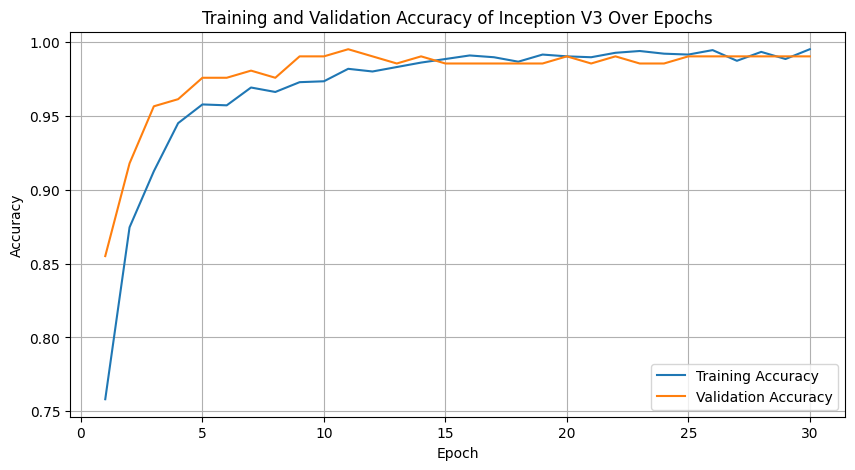

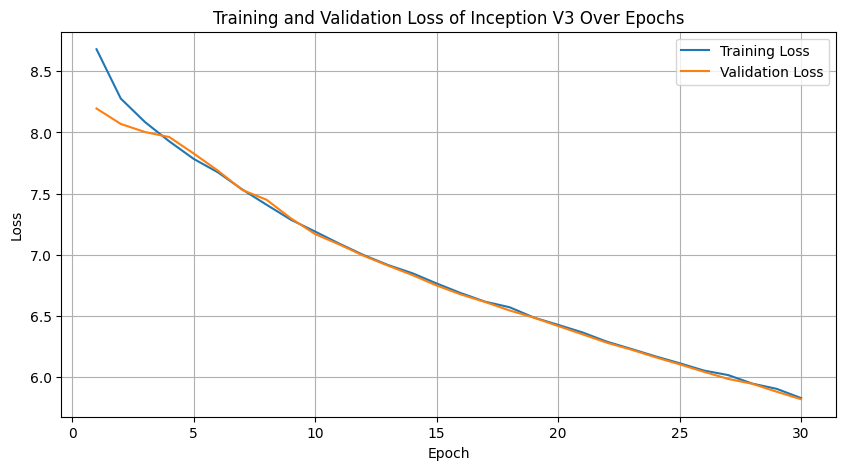

In [5]:
import os
import matplotlib.pyplot as plt

tr_loss = history.history['loss']
tr_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

epochs = range(1, len(tr_loss) + 1)

# Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, tr_acc, label='Training Accuracy', linestyle='-')
plt.plot(epochs, val_acc, label='Validation Accuracy', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy of Inception V3 Over Epochs')
plt.grid(True)
pdf_path = "H:/Thesis Figure/Inception V3 Accuracy.pdf"
plt.savefig(pdf_path, format='pdf')
plt.show()

# Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, tr_loss, label='Training Loss', linestyle='-')
plt.plot(epochs, val_loss, label='Validation Loss', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss of Inception V3 Over Epochs')
plt.grid(True)
pdf_path = "H:/Thesis Figure/Inception V3 Loss.pdf"
plt.savefig(pdf_path, format='pdf')
plt.show()

In [6]:
ts_length = len(test_df)
test_batch_size = max([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80])
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps=test_steps, verbose=1)
valid_score = model.evaluate(valid_gen, steps=test_steps, verbose=1)
test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


4/4 [==============================] - 0s 84ms/step - loss: 5.8235 - accuracy: 0.9583
Train Loss:  5.7789626121521
Train Accuracy:  1.0
--------------------
Validation Loss:  5.80914831161499
Validation Accuracy:  1.0
--------------------
Test Loss:  5.823467254638672
Test Accuracy:  0.9583333134651184


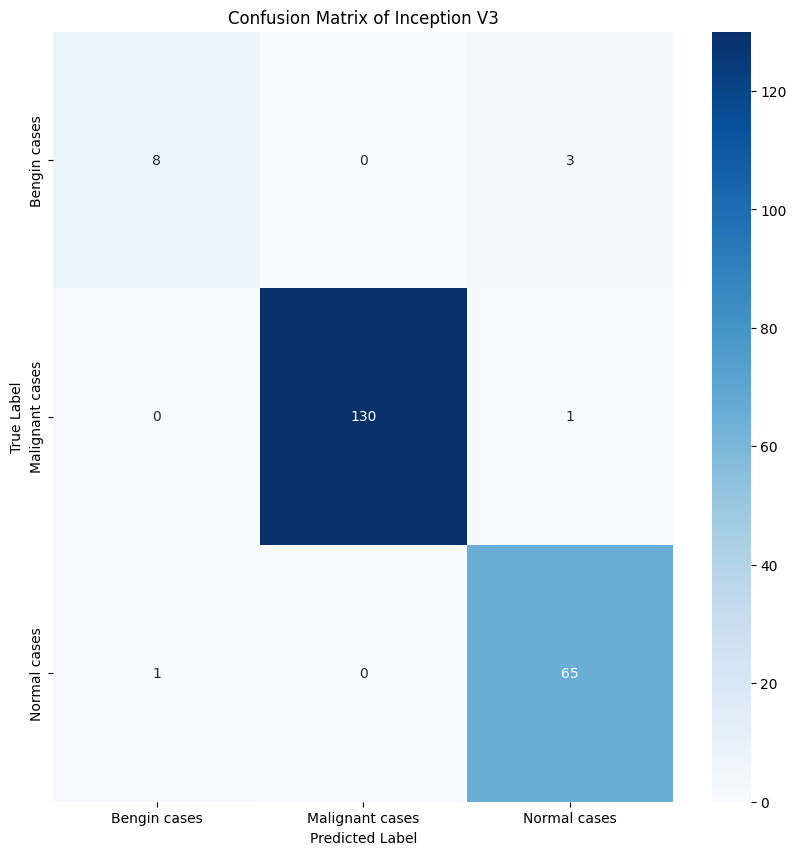

In [7]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Inception V3')
pdf_path = "H:/Thesis Figure/InceptionV3_CM.pdf"
plt.savefig(pdf_path, format='pdf', bbox_inches='tight')

plt.show()

In [8]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                 precision    recall  f1-score   support

   Bengin cases       0.89      0.73      0.80        11
Malignant cases       1.00      0.99      1.00       131
   Normal cases       0.94      0.98      0.96        66

       accuracy                           0.98       208
      macro avg       0.94      0.90      0.92       208
   weighted avg       0.98      0.98      0.98       208

